In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline

# Load Dataset

In [2]:
data = pd.read_csv('./data/conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


# Remove Outliers
Typically, age should be below 100. So, first let check outliers and clean the dataset

In [6]:
data[data['age'] > 90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


There are only two records that is invalid, let's first remove them directly

In [7]:
data = data[data['age'] < 100]

# Exploratory Data Analysis

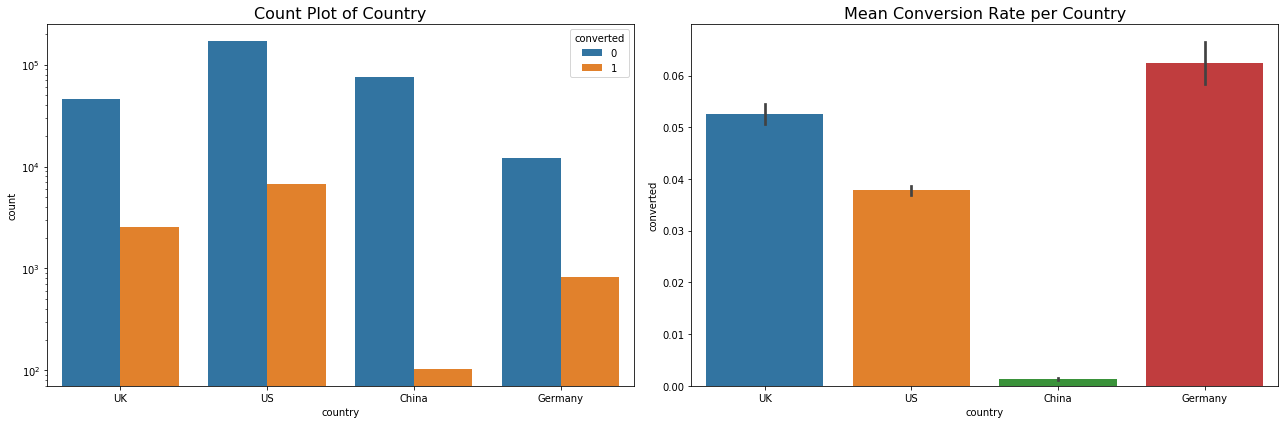

In [8]:
# Visualization of different countries
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

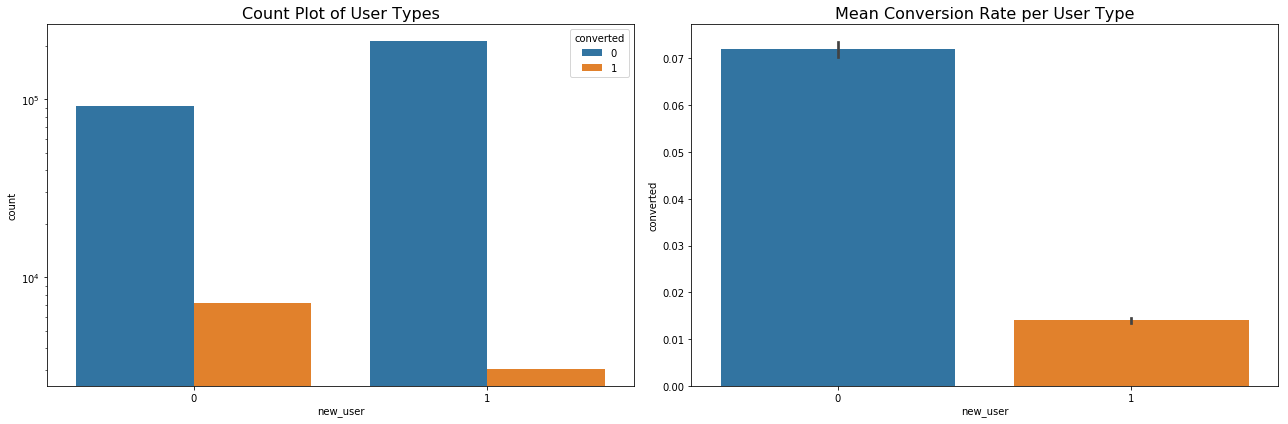

In [9]:
# Visualization of different user types
grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

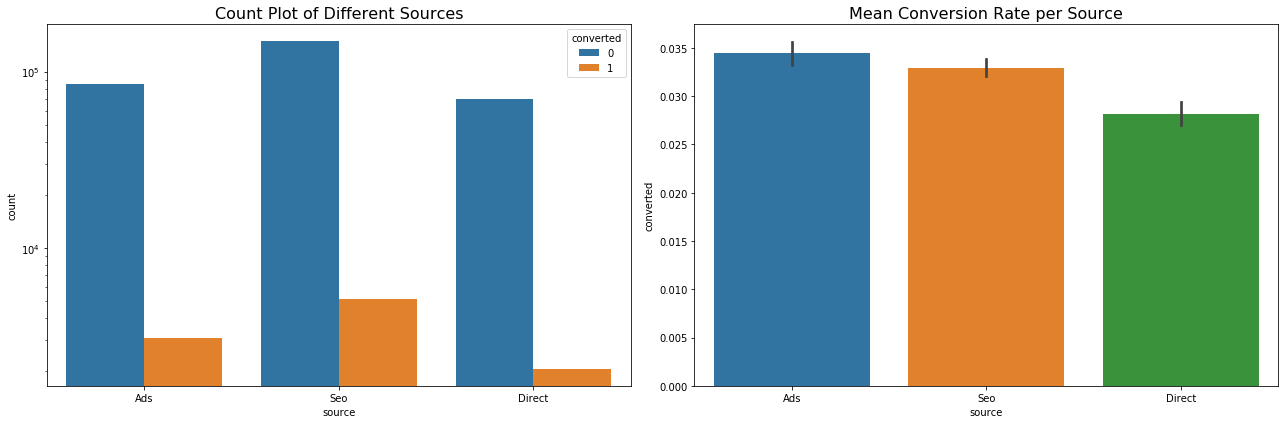

In [10]:
# Visualization of different sources
grouped = data[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

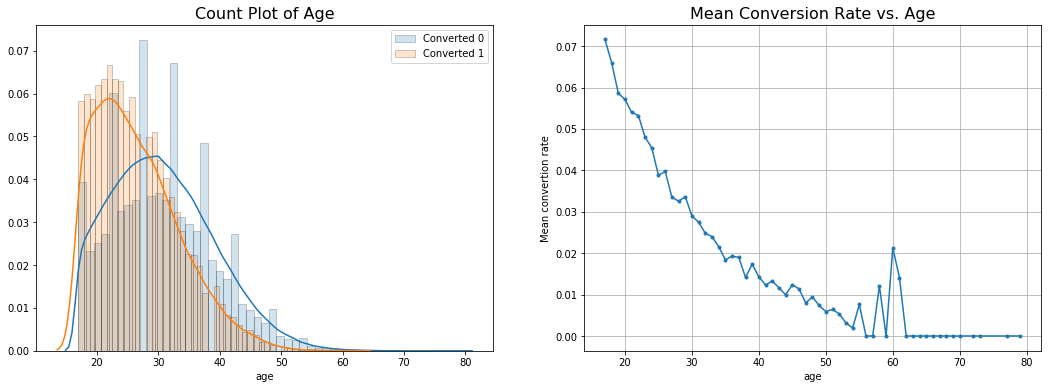

In [11]:
# Visualization of different sources
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

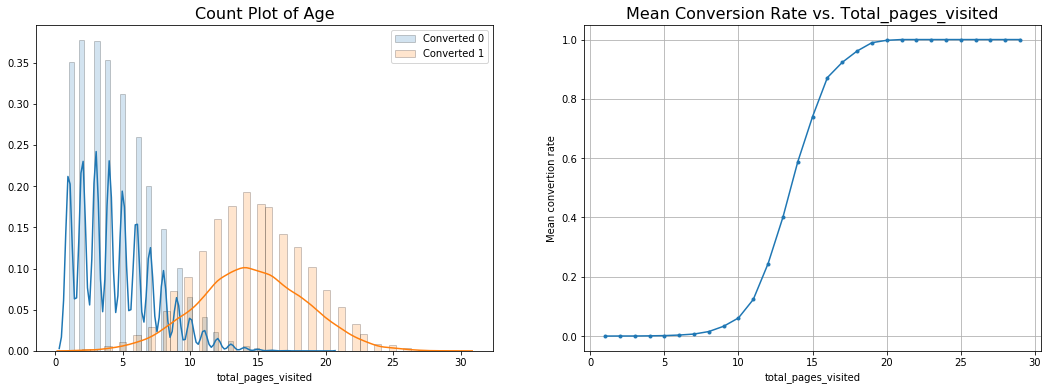

In [12]:
# Visualization of different sources
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

# Machine Learning

In [13]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-macosx) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-macosx) (build 25.121-b15, mixed mode)
  Starting server from /anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gx/b15jqbt1567grsfr7l_znn2h0000gn/T/tmp1nzunibu
  JVM stdout: /var/folders/gx/b15jqbt1567grsfr7l_znn2h0000gn/T/tmp1nzunibu/h2o_jifu_started_from_python.out
  JVM stderr: /var/folders/gx/b15jqbt1567grsfr7l_znn2h0000gn/T/tmp1nzunibu/h2o_jifu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,1 month and 29 days
H2O cluster name:,H2O_from_python_jifu_8qu6ph
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [14]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [15]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [16]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


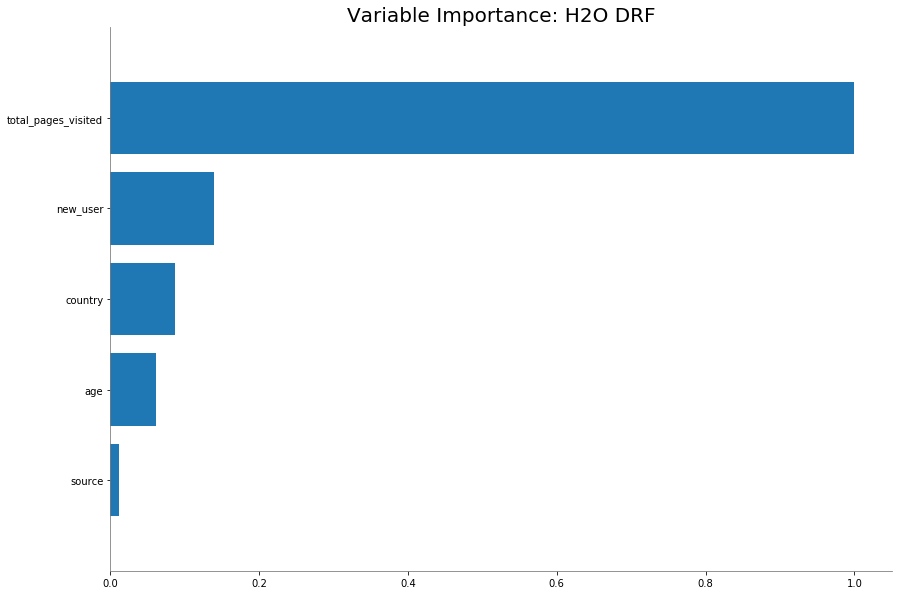

In [17]:
model.varimp_plot()

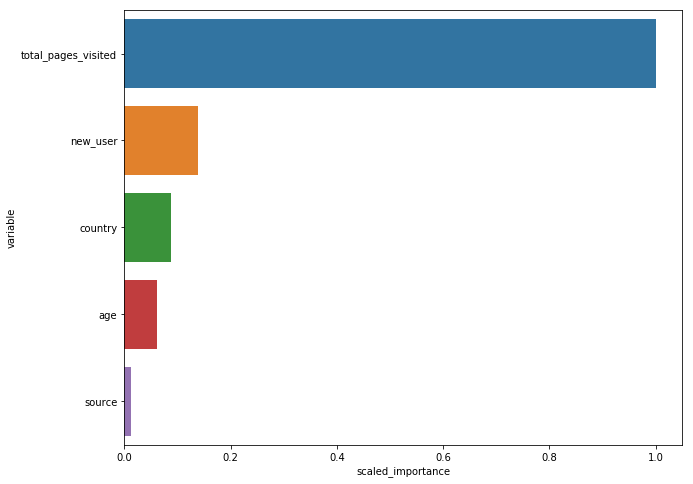

In [18]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [19]:
# Make predictions
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [20]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     76500
          1       0.84      0.63      0.72      2550

avg / total       0.98      0.98      0.98     79050



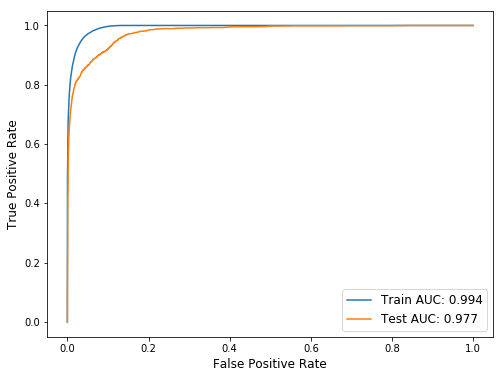

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


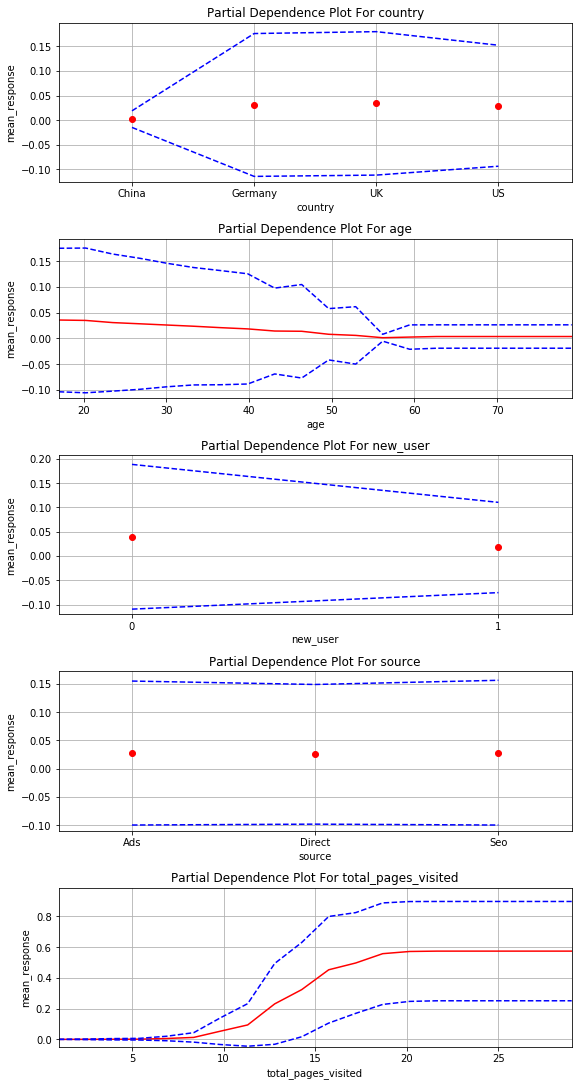

In [22]:
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

In [23]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_8322 closed.
